# Link Analysis
Conducting a link analysis of a network graph involves identifying and analyzing the link within the graph. 

In [1]:
import pandas as pd
import numpy as np
from os.path import join
import os


from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('../data/snapshot_selection.csv')
df_tokens = pd.read_csv("../data/final_token_selection.csv")


/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.path.append('..') 

from src.analysis.link_analysis_class import * 
from src.visualisations.link_analysis_visualisations import * 

## Create dataframes for each metrics

In [3]:
import pickle

# Specify the path to the file containing the saved cliques data
links_data_path = join(path, 'data/links_data_class.pkl')
links_data = LinkData(links_data_path)


# Use the metric_names attribute from CliquesData
metric_names = links_data.metric_names


# Initialize an empty dictionary to store DataFrames for each metric
metric_dataframes = {'sample': {},'control': {},'pvalues': {}}     

# Create DataFrames for each metric

for group in ['sample', 'control', 'pvalues']:
    for metric_name in metric_names:
        metric_dataframes[group][metric_name] = links_data.get_metric_data(group, metric_name)

## Figure Generation

### Fig: Size of Clique 

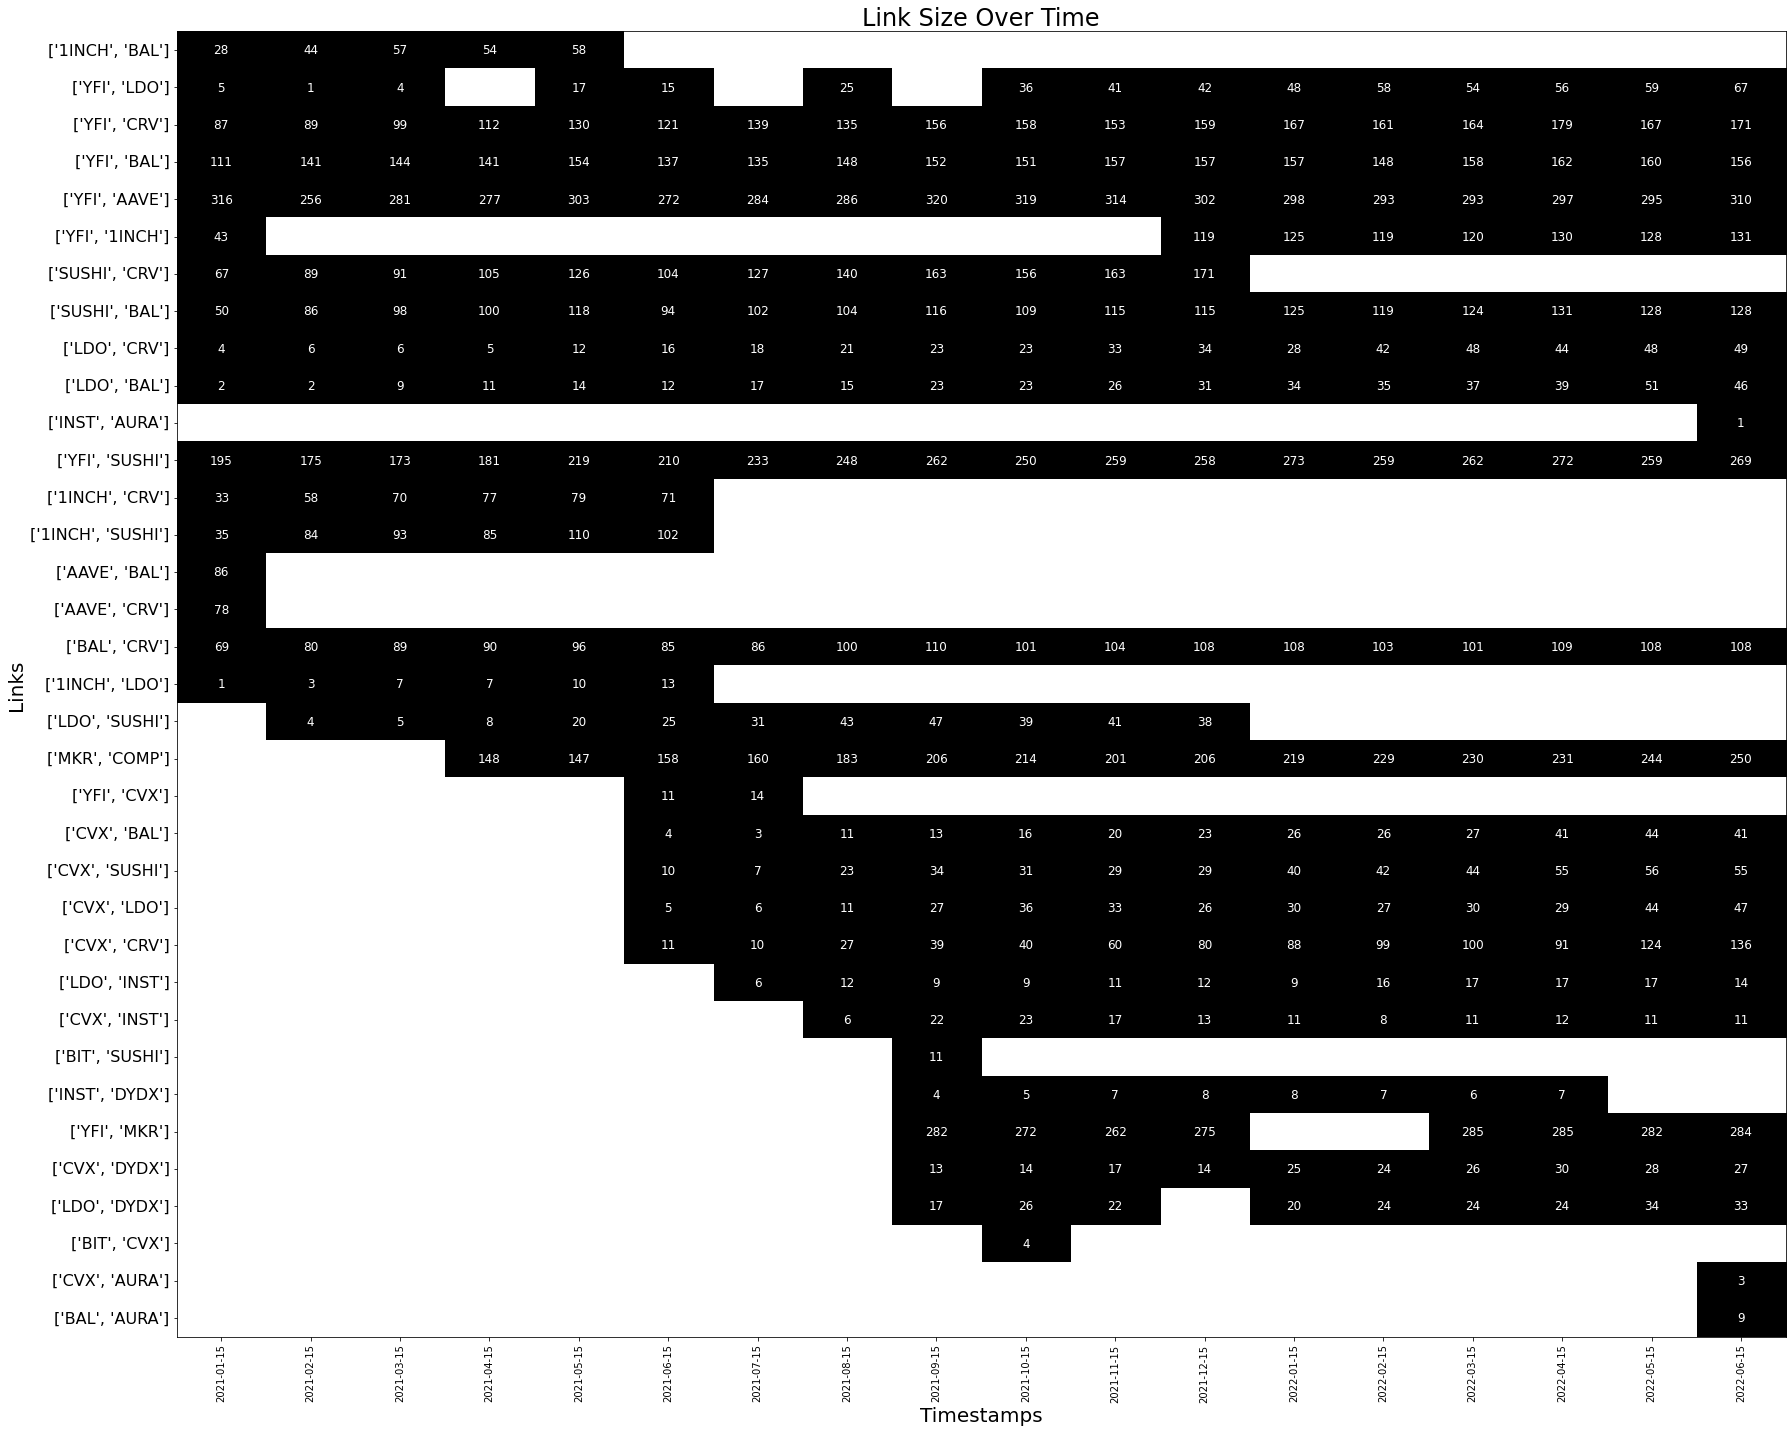

In [4]:
plot_link_size_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

### Fig: link growth over time 

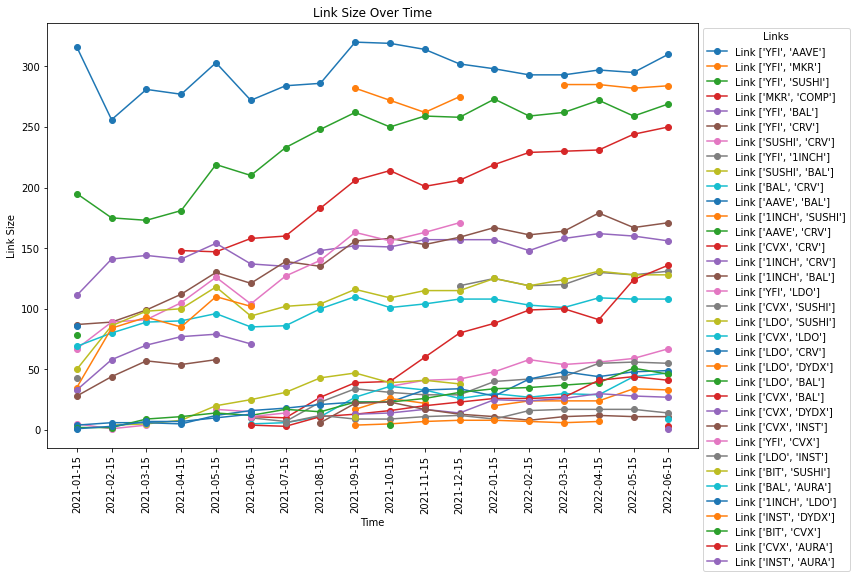

In [5]:
plot_link_growth_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

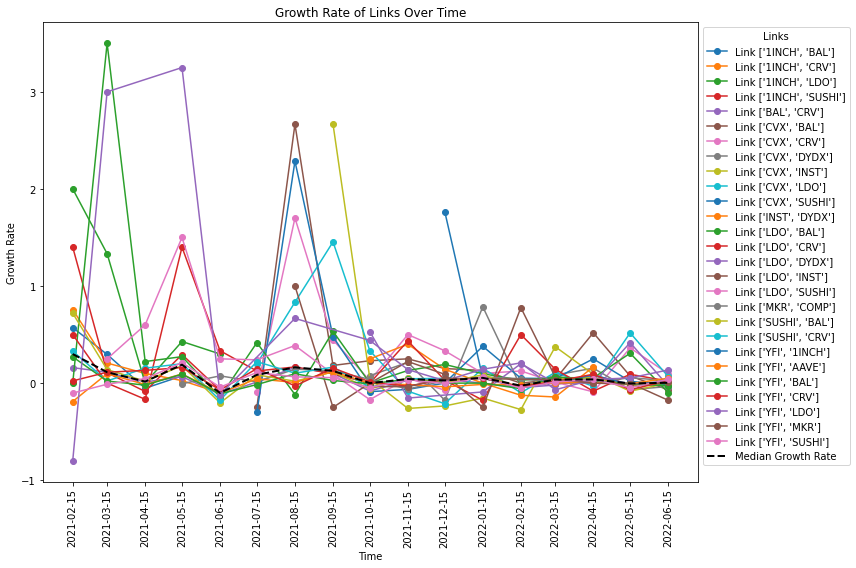

In [6]:
 plot_link_growth_rate_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

/home/user/eisermann/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/user/eisermann/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


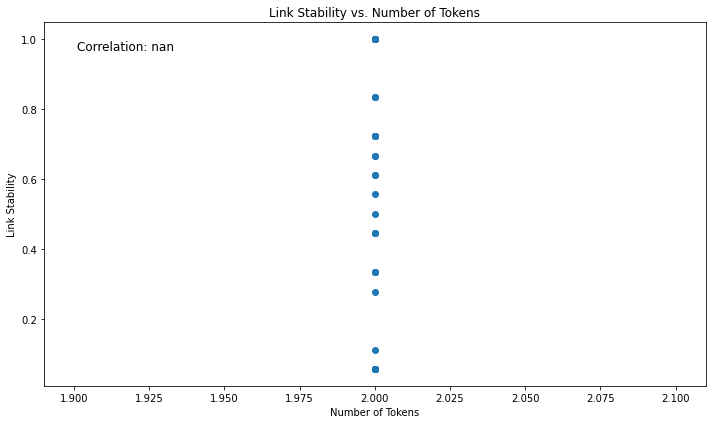

In [7]:
plot_link_stability_vs_no_of_tokens(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

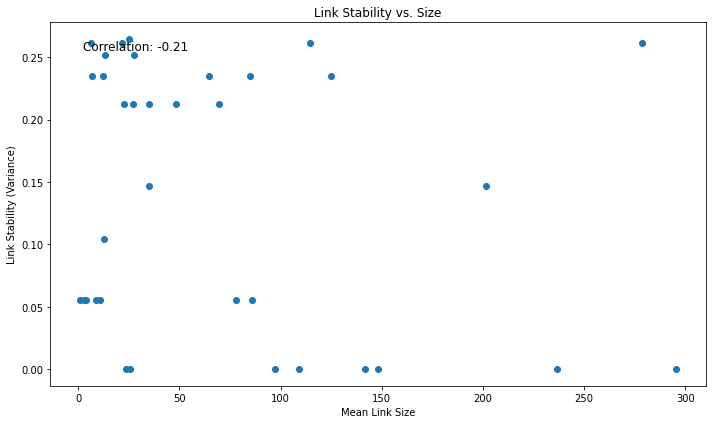

In [8]:
plot_link_stability_vs_size(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

### Fig: link_size vs total_influence 

In [9]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define dfs
#     df_size = metric_dataframes[method][group]['size_clique']
#     df_influence = metric_dataframes[method][group]['total_influence']

#     # Calculate correlations for each timestamp
#     correlations = df_size.corrwith(df_influence, axis=0)

#     # Plotting the correlations
#     plt.figure(figsize=(10, 5))
#     plt.plot(correlations.index, correlations, marker='o', linestyle='-')
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Correlation between Clique Size and Total Influence', fontsize=12)
#     plt.title(f'[{method.upper()}]: Correlation of Clique Size and Total Influence Over Time', fontsize=14)
#     plt.grid(True)

#     plt.xticks(rotation=90)  # Rotate x-tick labels by 90 degrees

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'clique_size_influence_correlation_{method}_{group}.png'))

#     if show:
#         plt.show()
#     else:
#         plt.close()

# # Example usage
# plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)


### Fig: total_influence

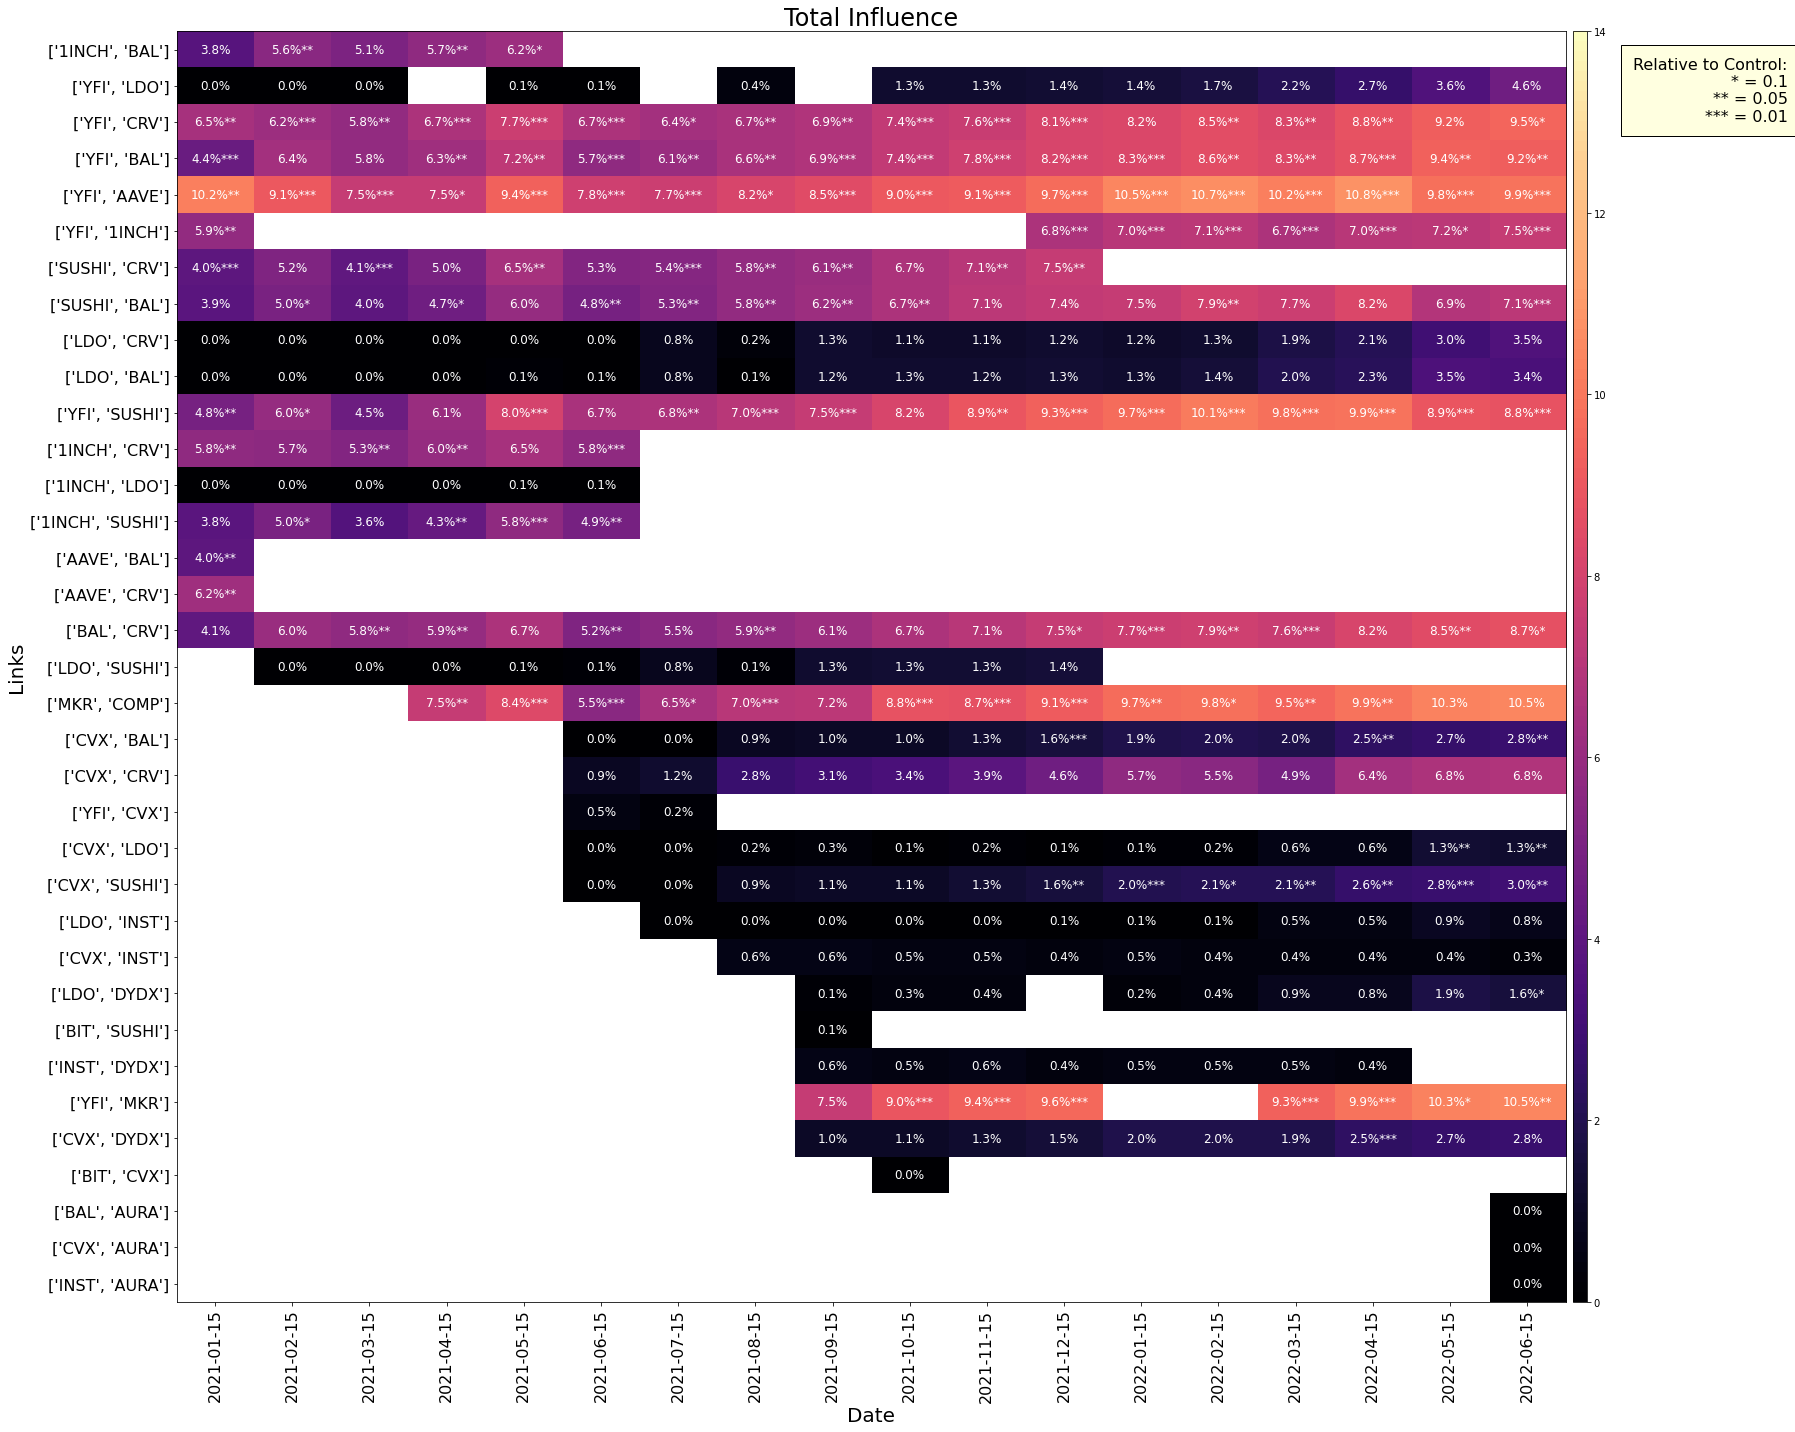

In [10]:
plot_heatmap_chart(metric_dataframes, metric_name='total_influence', pct=True,  log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_total_influence

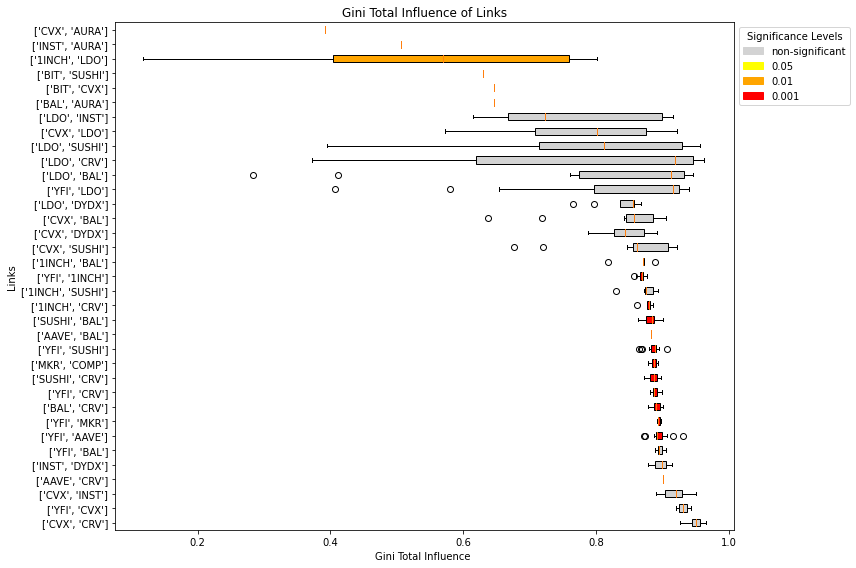

In [11]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_total_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: internal_influence 

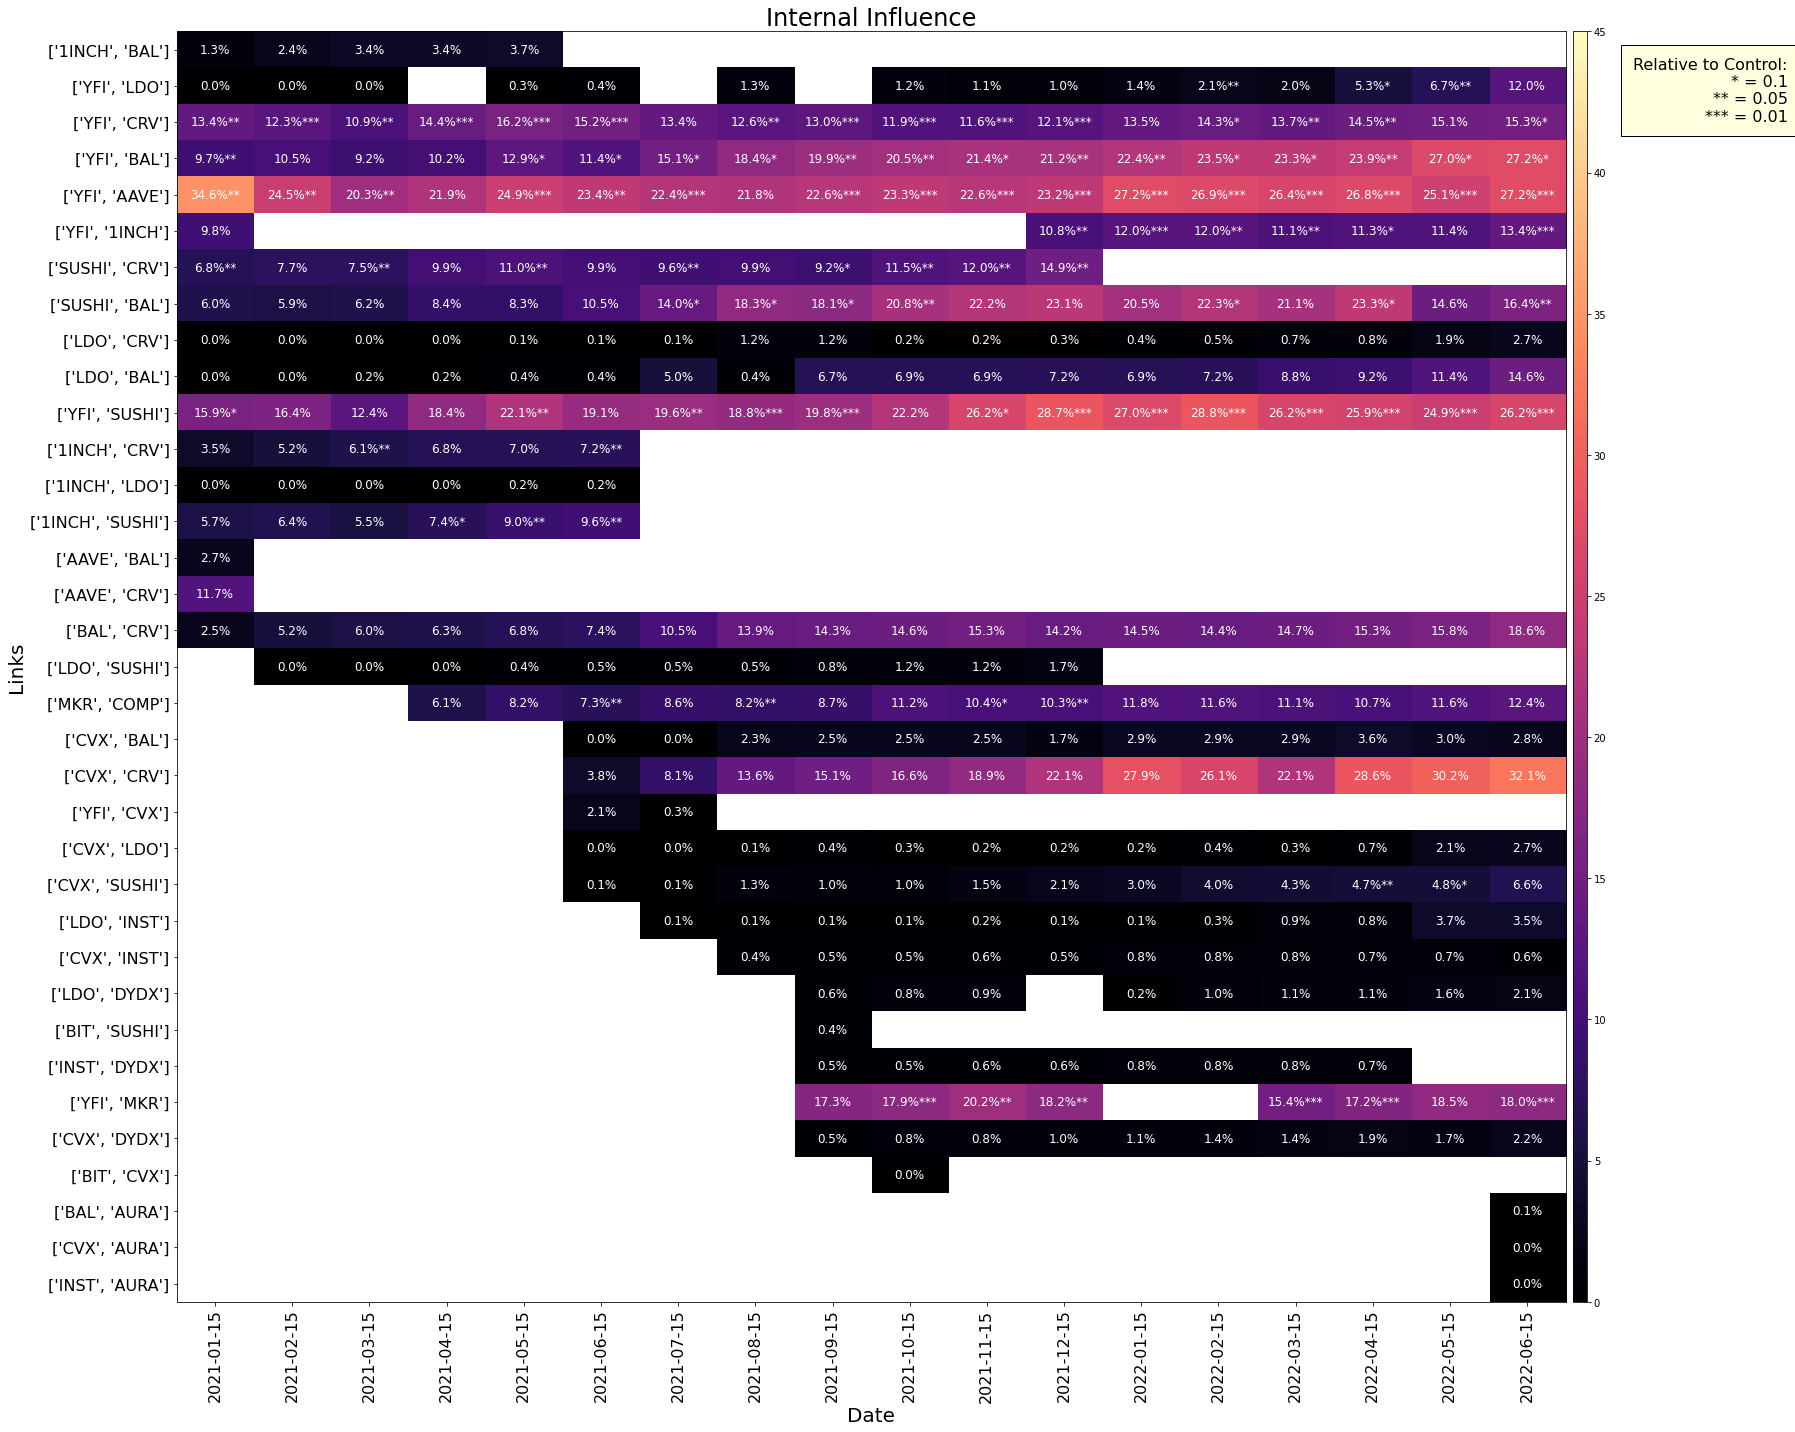

In [12]:
plot_heatmap_chart(metric_dataframes, metric_name='internal_influence', pct=True,  log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_internal_influence 

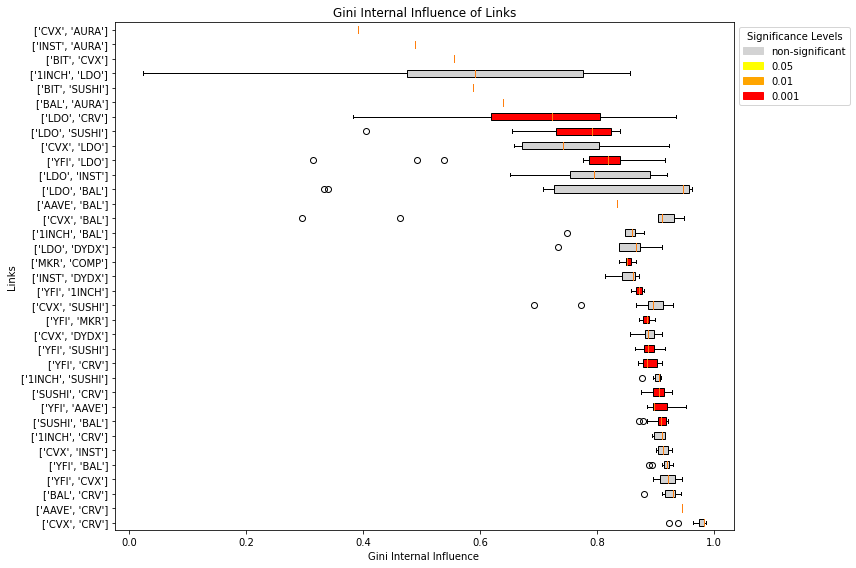

In [13]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_internal_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: external_influence

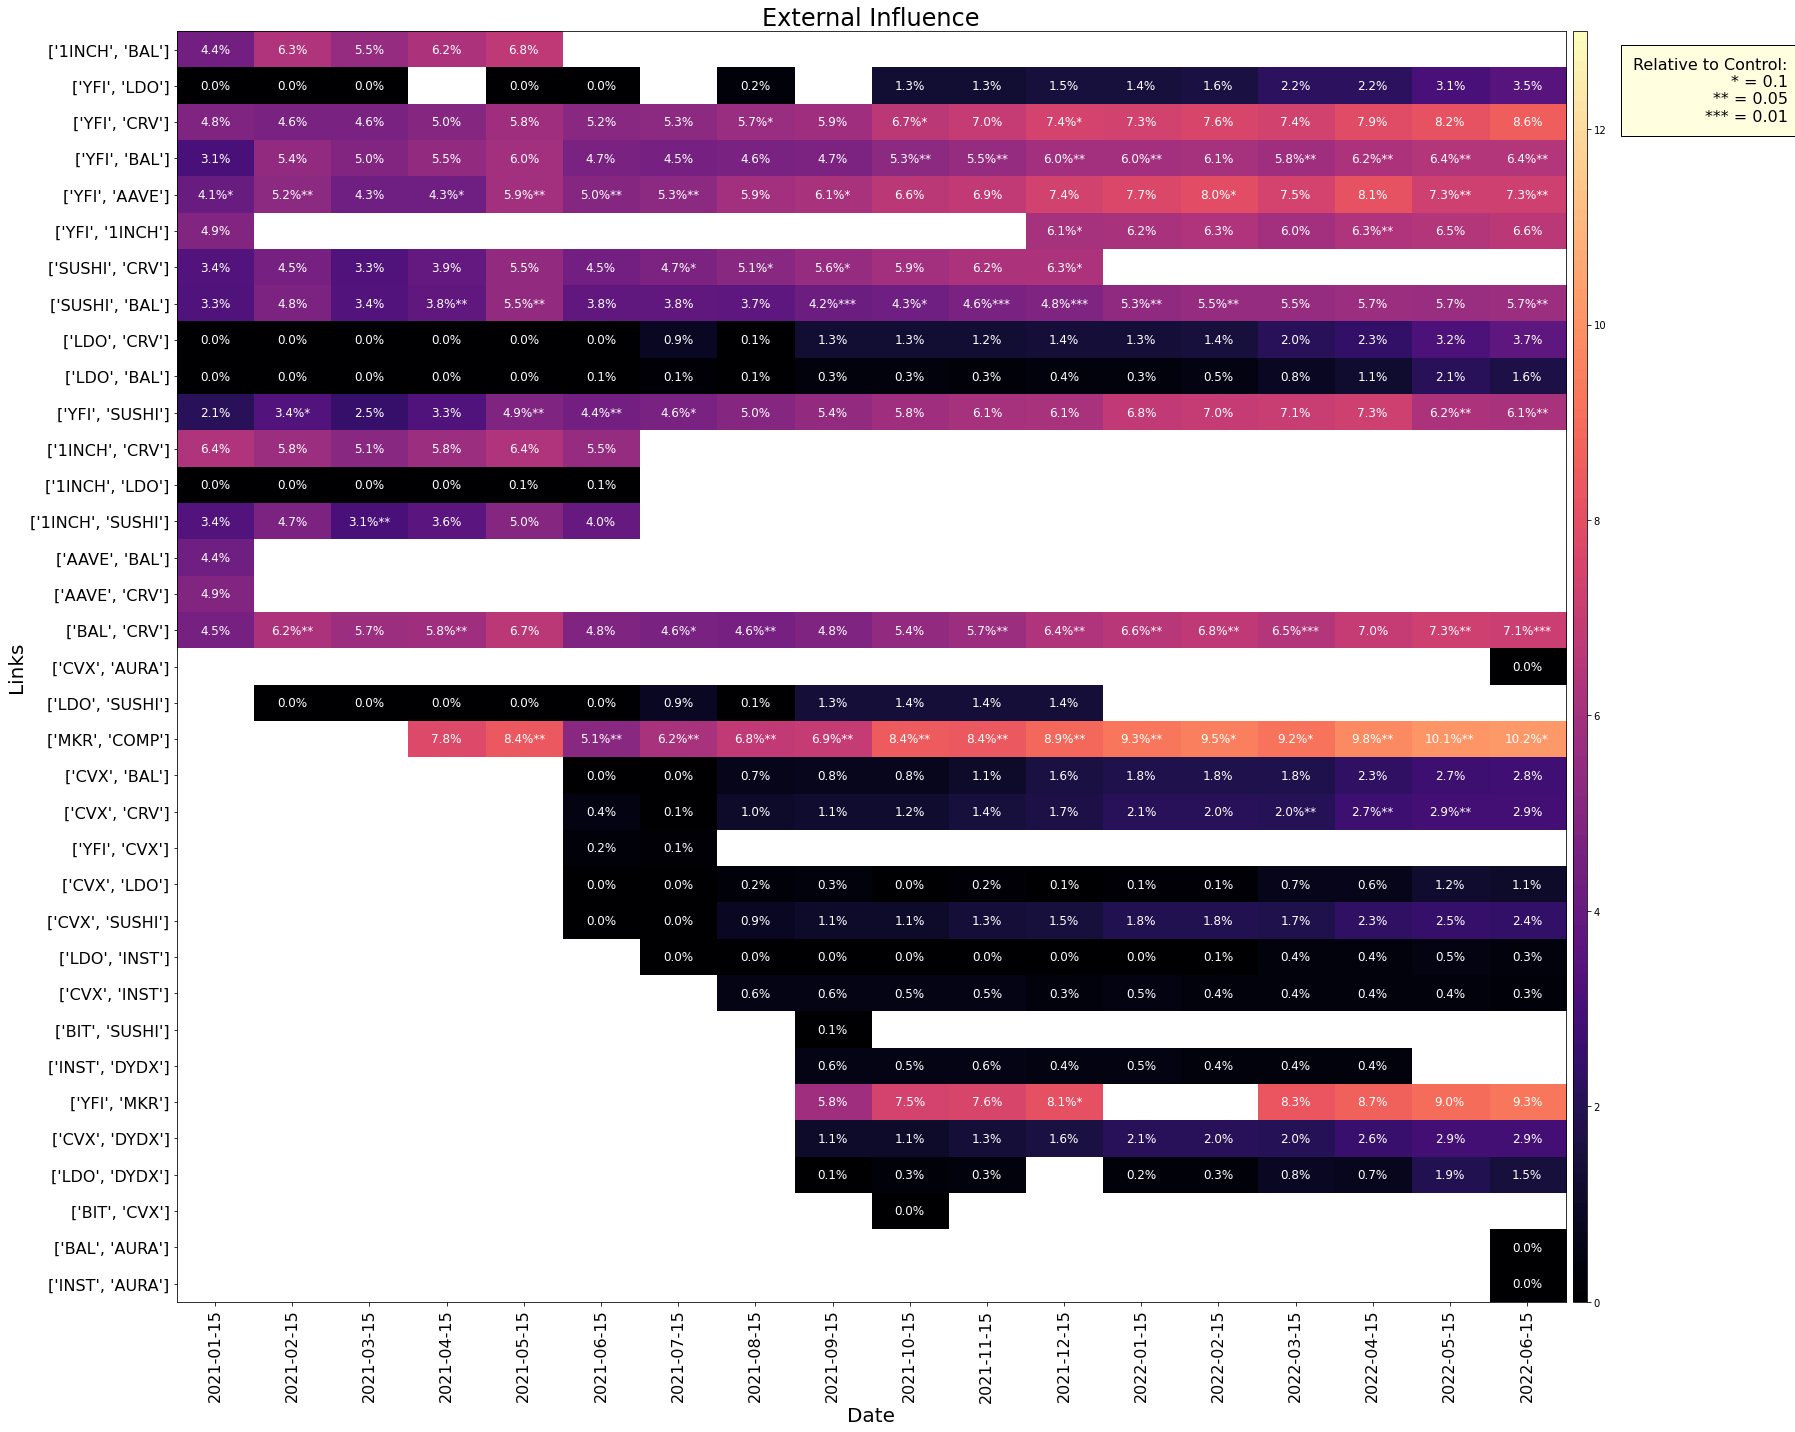

In [14]:
plot_heatmap_chart(metric_dataframes, metric_name='external_influence', pct=True, log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_external_influence

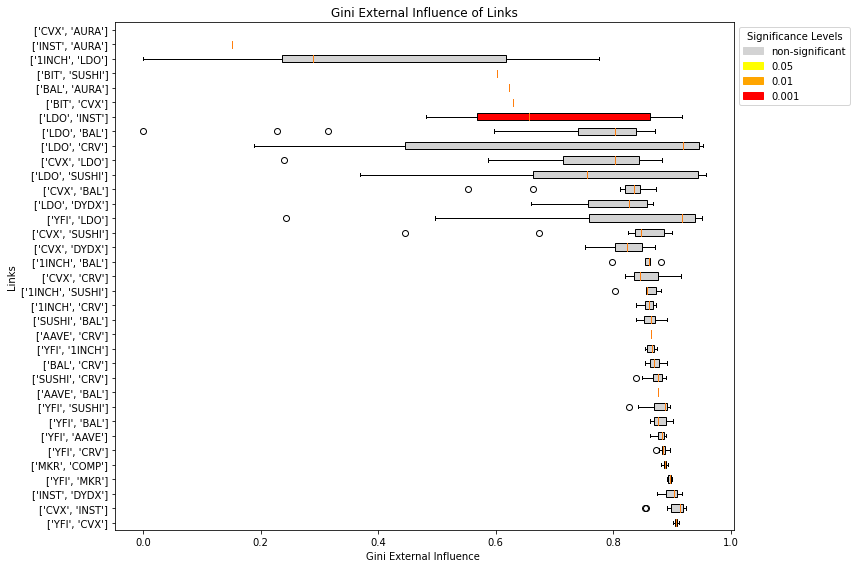

In [15]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_external_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: wealth_clique


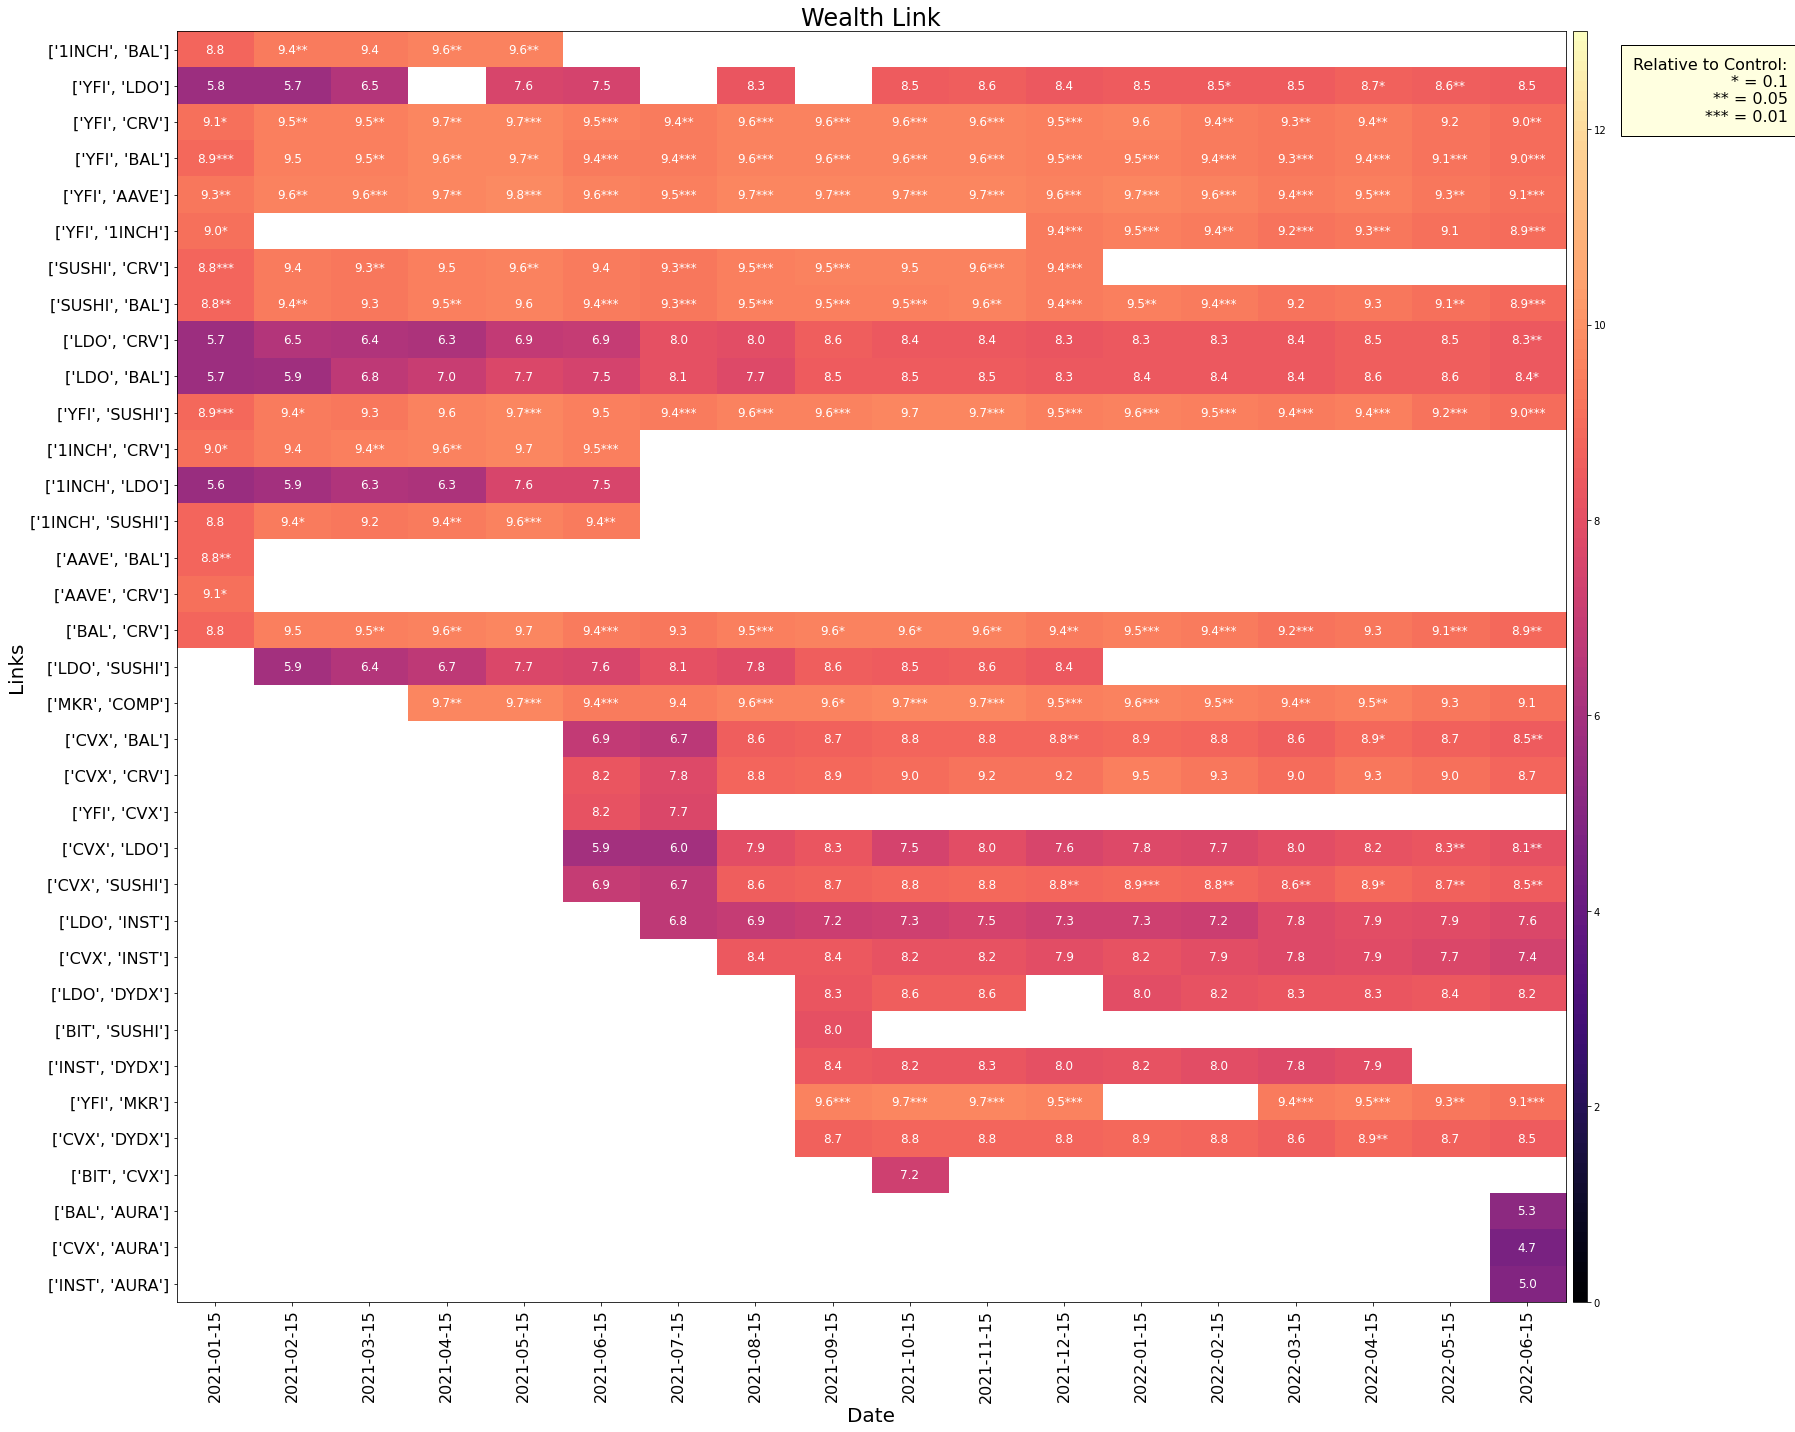

In [16]:
plot_heatmap_chart(metric_dataframes, metric_name='wealth_link', pct=False, log=True, output_path="../output/links/", save=False, show=True)

### Fig: gini_wealth_clique

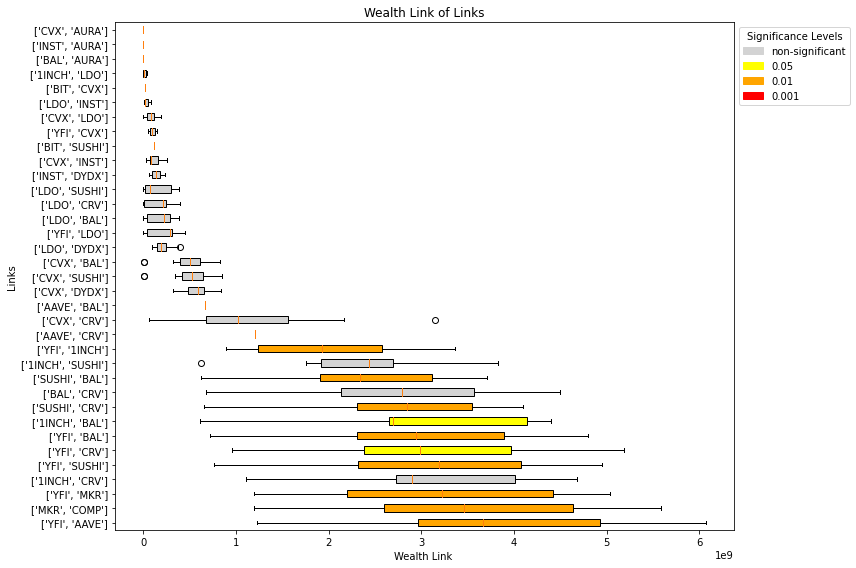

In [17]:

plot_boxplot_with_significance(metric_dataframes, metric='wealth_link', unit='', group='sample', output_path="../output/links/", save=True, show=True)


### Fig: median_no_assets_link


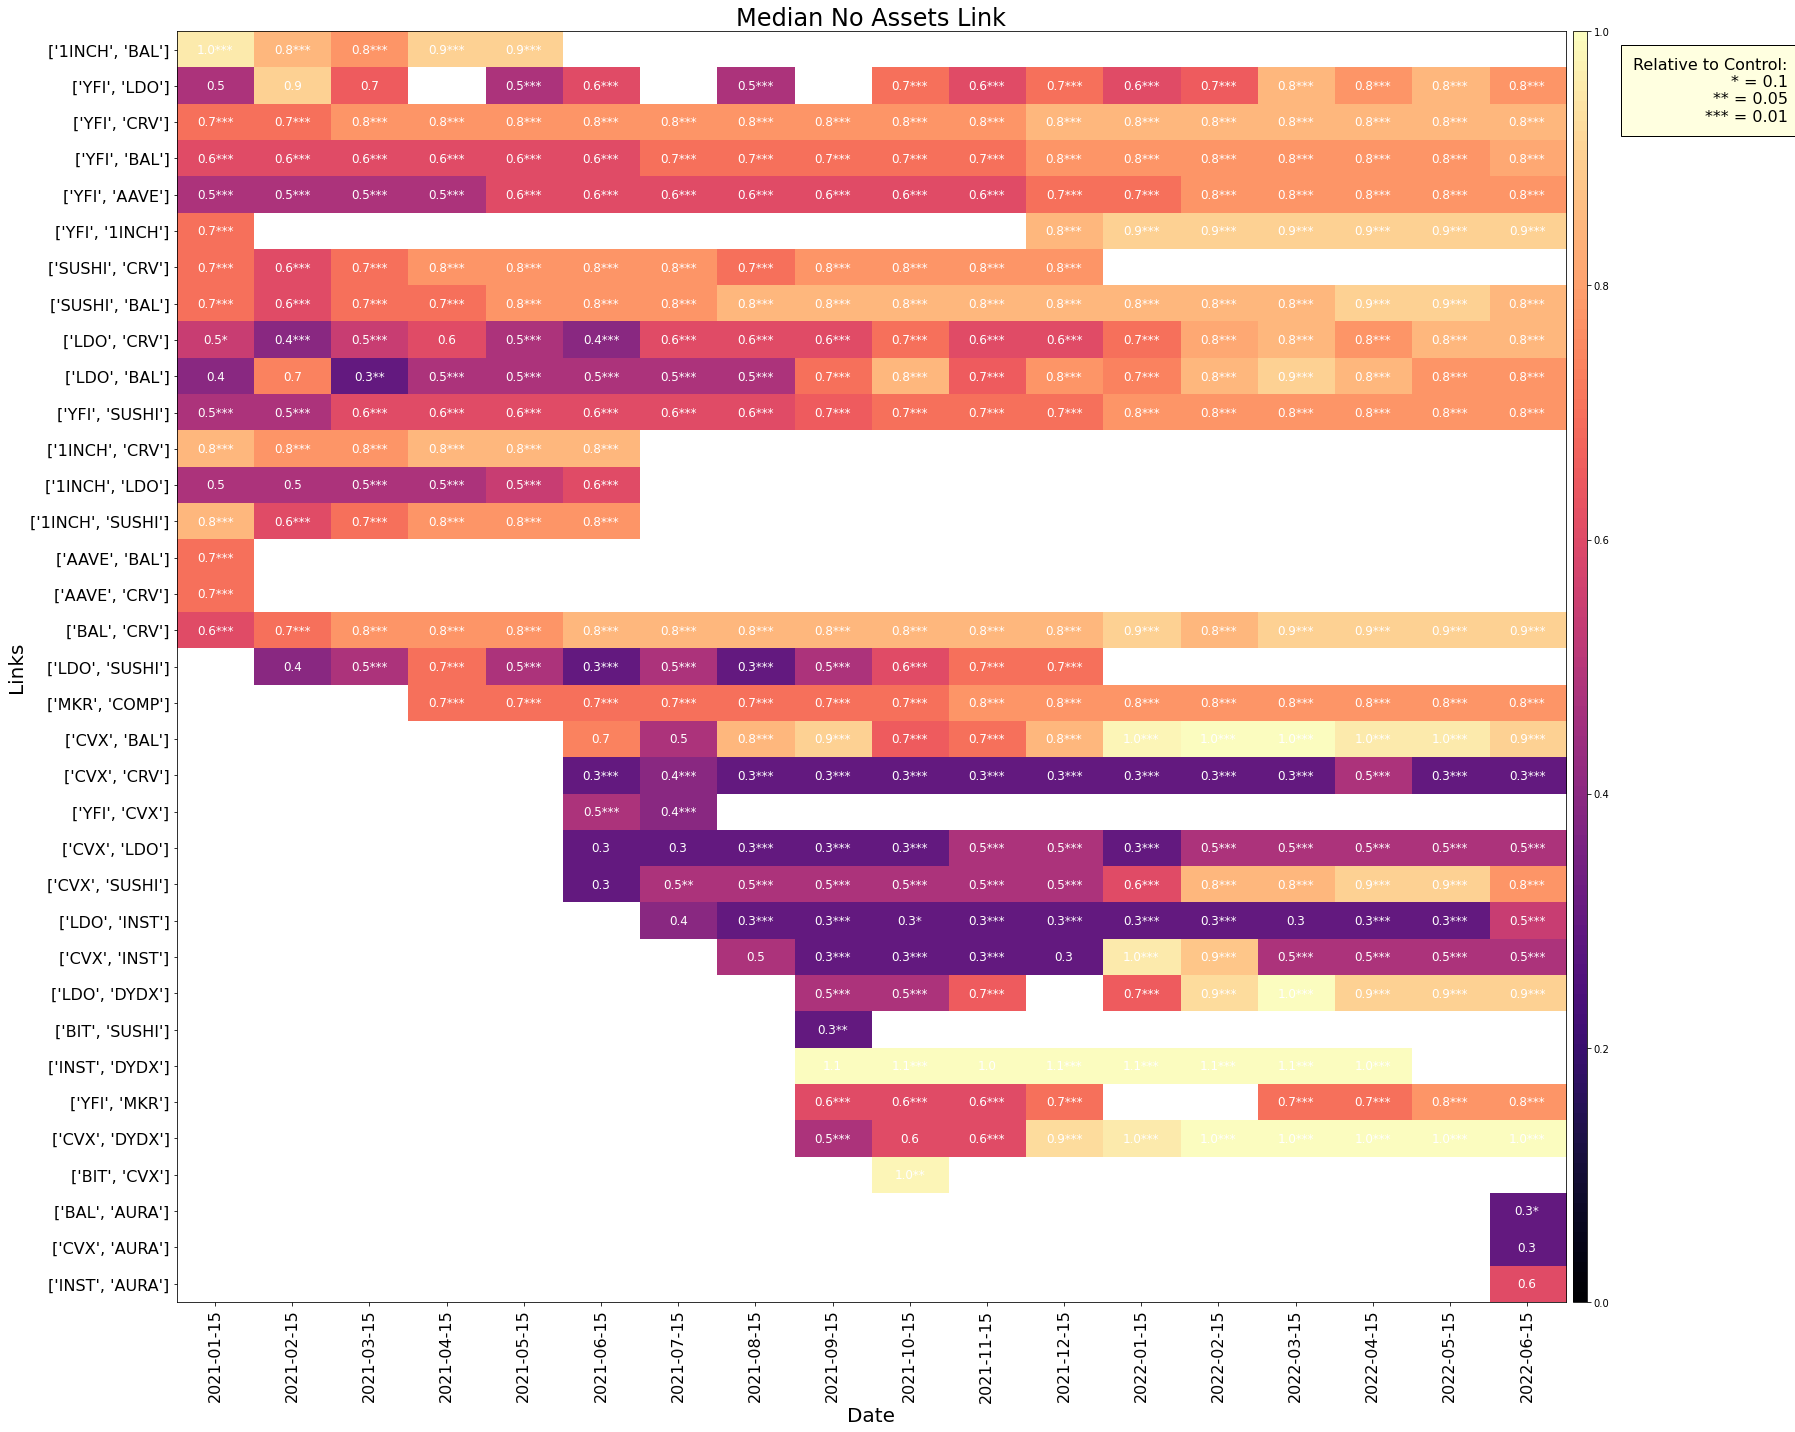

In [18]:
plot_heatmap_chart(metric_dataframes, metric_name='median_no_assets_link', pct=False, log=True, output_path="../output/links/", save=False, show=True)

### Fig: Distribution of Labels

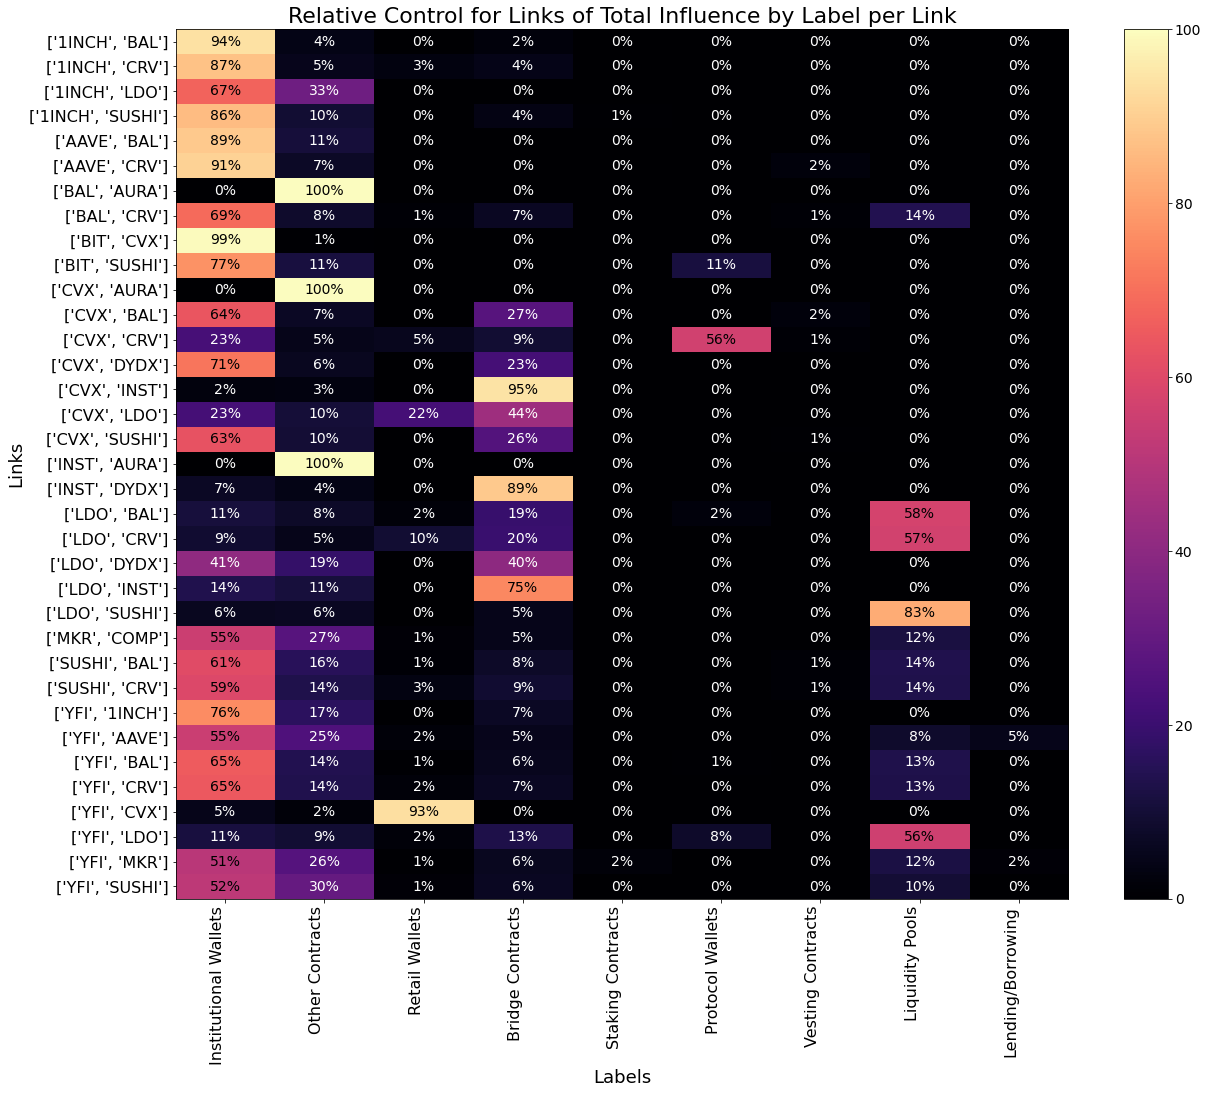

In [19]:
plot_heatmap_labels(metric_dataframes, group='sample', colormap='magma', output_path='../output/links')